In [58]:
# Imports for Grady's NN Files
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib import style
from matplotlib.patches import Rectangle
import csv
import time
import random
from numpy.linalg import norm
from numpy import (array, dot, arccos, clip)
from matplotlib.ticker import FormatStrFormatter

from tkinter import *
import random

from IPython.core.debugger import set_trace

__Note:__ We're interested in the algorithms' ability to follow an "optimal" (for now random) path, so we don't need to generate them in _real time_. Which makes it ok to pre-compute the waypoints as opposed to generate them on the fly.

## <center> Path Generation Based on Existing Waypoints </center>

In [2]:
# Getting existing waypoints
fileName = 'Waypoints.txt'
def getWaypoints(fileName):
    f = open(fileName, 'r')
    r = csv.reader(f, delimiter=',')
    xy = [row for row in r]
    x = [float(row[0]) for row in xy]
    y = [float(row[1]) for row in xy]
    f.close()
    return x, y 

# Generating new randomized waypoints from file
def generateWaypoints(fileName, var):
    x, y = getWaypoints(fileName)
    xnew = [(i + random.uniform(-var, var)) for i in x]
    ynew = [(i + random.uniform(-var, var)) for i in y]
    return xnew, ynew

# Generating new randomized waypoints given input series of points
def generateWaypoints2(x, y, xvar, yvar):
    xnew = [(i + random.uniform(0, xvar)) for i in x]
    ynew = [(i + random.uniform(-yvar, yvar)) for i in y]
    xnew = [0] + xnew
    ynew = [0] + ynew
    return xnew, ynew

In [91]:
waypoints = 'Waypoints.txt'
x_waypoints, y_waypoints = getWaypoints(waypoints)
xrand1, yrand1 = generateWaypoints(waypoints, 0.5)
xrand2, yrand2 = generateWaypoints(waypoints, 1.0)
xrand3, yrand3 = generateWaypoints(waypoints, 1.5)

# Plotting (COMMENTED OUT FOR NOW, tryng simpler paths)
#f1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5), sharex='col', sharey='row')
#f1.suptitle(r'Original vs. Randomized waypoints (with variance $\sigma = 0.5, 1.0, 1.5$)')
#ax1.plot(x_waypoints, y_waypoints)
#ax2.plot(xrand1, yrand1)
#ax3.plot(xrand2, yrand2)
#ax4.plot(xrand3, yrand3)

In [111]:
# GENERATING WAYPOINTS RANDOMLY SAMPLED ABOUT THE X AXIS
xVariance = 10
yVariance = 5
totalDistance = 10
NUM_OF_WAYPOINTS = 2

x_evenly_spaced = np.linspace(0, totalDistance, NUM_OF_WAYPOINTS)
y_evenly_spaced = np.linspace(0, 0, NUM_OF_WAYPOINTS)
x_waypoints, y_waypoints = generateWaypoints2(x_evenly_spaced, y_evenly_spaced, xVariance, yVariance)

Text(0.5,0.98,'Waypoints')

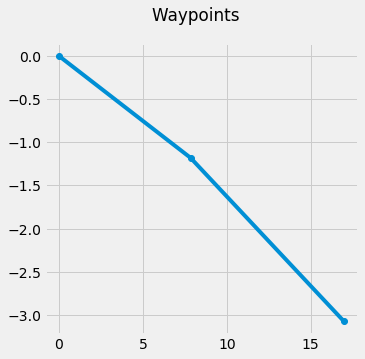

In [112]:
f1, ((ax1)) = plt.subplots(1, 1, figsize=(5, 5), sharex='col', sharey='row')
ax1.plot(x_waypoints, y_waypoints, 'o-')
f1.suptitle(r'Waypoints')
#ax1.set_ylim([-10, 10])
#ax1.set_xlim([0, 20])

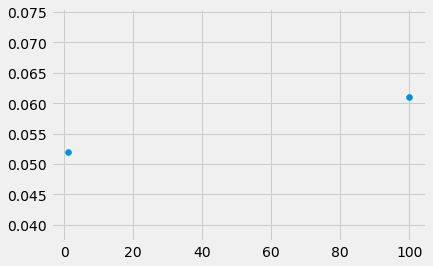

In [113]:
# Testing Throttle PID: Getting PID Values if car had 0 velocity at every waypoint, with lastError = 0 and lastIterm = 0
throttleAtPoints = []
for i, j in zip(range(0, len(x_waypoints) - 1), range(0, len(y_waypoints)-1)):
    distanceBetweenPoints = np.sqrt((x_waypoints[i+1] - x_waypoints[i])**2 + (y_waypoints[i + 1] - y_waypoints[i])**2)
    velocityTarget = distanceBetweenPoints / 10
    sumPID, pastError, ITerm = throttlePID(0, velocityTarget, 0, 0, 0.1)
    throttleAtPoints.append(sumPID)

plt.scatter(np.linspace(1, 100,len(throttleAtPoints)), throttleAtPoints)

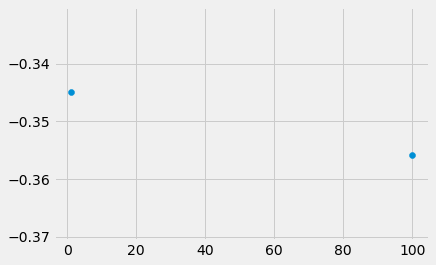

In [114]:
# Testing Steering PID: Same as for throttle PID
steeringAtPoints = []
initial_heading_degrees = 0
for i, j in zip(range(0, len(x_waypoints) - 1), range(0, len(y_waypoints)-1)):
    steeringInput, lastSteerError, ITerm, P, I = steeringPID(x_waypoints[i], y_waypoints[i], x_waypoints[i + 1], y_waypoints[i + 1], 0, 0, 0.02, initial_heading_degrees * math.pi / 180)
    steeringAtPoints.append(steeringInput)

plt.scatter(np.linspace(1, 100,len(steeringAtPoints)), steeringAtPoints)

## <center> Throttle PID Controller (2D Cartesian) </center>
__Note:__ May need to implement smoothing depending on how well this runs

In [8]:
# INPUTS: Current x position, current y position, desired x position, desired y position, whether we just passed a point,
#         time difference since last point
# OUTPUTS: The THROTTLE value to apply, the position error (for future D calculations)
def throttlePID(velocityCurrent, velocityTarget, lastError, ITerm, dtime):
    # 0. Defining random gains
    kp = 0.015
    ki = 0.0005
    kd = 0.005
    ITermMin = -1
    ITermMax = 1
    
    # 1. Find error based on absolute distance between current position and desired position
    velocityError = velocityTarget - velocityCurrent
    
    # 3. Obtain P, I, and D values:
    ## P
    PTerm = kp * velocityError
    
    ## I
    ITerm += ki * velocityError
    if (ITerm > ITermMax):
        ITerm = ITermMax
    elif (ITerm < ITermMin):
        ITerm = ITermMin;
    
    #D
    dError = (velocityError - lastError) / dtime
    DTerm = kd * dError;
    
    sumPID = PTerm + ITerm + DTerm
    return (sumPID, velocityError, ITerm)

## <center> Steering PID Controller </center>

In [123]:
# INPUTS: Current x position, current y position, desired x position, desired y position, whether we just passed a point,
#         time difference since last point
# OUTPUTS: The STEERING value to apply, the angular error (for future D calculations)
def steeringPID(x_current, y_current, x_target, y_target, lastError, ITerm, dtime, headingCurrent):
    # 0. Defining random gains
    kp = 0.2
    ki = 0.0
    kd = 0.0
    ITermMin = -2
    ITermMax = 2
    ITerm = 0
    
    # 2. Find error based on angle between current heading direction and direction to target point
    xDiff = x_target - x_current
    yDiff = y_target - y_current
    #print(xDiff, yDiff)
    heading_target = np.arctan2(xDiff, yDiff)
    #print(heading_target * 180/np.pi)
    angularError = headingCurrent - heading_target
    #print(angularError * 180/np.pi)
    
    # 3. Obtain P, I, and D values:
    ## P
    PTerm = kp * angularError
    
    ## I
    ITerm += ki * angularError
    if (ITerm > ITermMax):
        ITerm = ITermMax
    elif (ITerm < ITermMin):
        ITerm = ITermMin;
    
    #D
    dposition = (angularError - lastError) / dtime
    DTerm = kd * dposition;
    
    sumPID = PTerm + ITerm + DTerm
    return (sumPID, angularError, ITerm, PTerm, ITerm)

## <center> Neural Network State Estimator (Grady's stuff) </center>

In [10]:
class AutoRallyNet:

    def __init__(self, save_path, dt = 0.02):
        self.weight_dict = np.load(save_path)
        self.non_linearity = np.tanh
        self.dt = dt
    
    def __call__(self, x, steering, throttle):
        state = np.copy(x) #Don't modify x, return updated state as new variable
        #First compute the state derivative
        fn_input = np.concatenate([state[3:], [steering], [throttle]])
        h1 = np.dot(self.weight_dict["dynamics_W1"], fn_input) + self.weight_dict["dynamics_b1"]
        h1 = np.tanh(h1)
        h2 = np.dot(self.weight_dict["dynamics_W2"], h1) + self.weight_dict["dynamics_b2"]
        h2 = np.tanh(h2)
        state_der = np.dot(self.weight_dict["dynamics_W3"], h2) + self.weight_dict["dynamics_b3"]
        #Now compute the actual state update
        state[0] += (np.cos(state[2])*state[4] - np.sin(state[2])*state[5])*self.dt
        state[1] += (np.sin(state[2])*state[4] + np.cos(state[2])*state[5])*self.dt
        state[2] += -state[6]*self.dt #Sixth state is NEGATIVE of yaw derivative
        state[3] += state_der[0]*self.dt
        state[4] += state_der[1]*self.dt
        state[5] += state_der[2]*self.dt
        state[6] += state_der[3]*self.dt
        return state

In [140]:
def animate(npy_array, name):
    save_as = name + ".mp4"
    Xs = npy_array[:, 0]
    Ys = npy_array[:, 1]
    Yaw = npy_array[: ,2]
    Vx = npy_array[:, 4]
    Vy = npy_array[:, 4]*np.tan(npy_array[:, 3])
    T = range(Xs.size)
    fig = plt.figure()
    ax = plt.axes(xlim=(0,20), ylim = (-10,10))
    Xs = np.array(Xs)
    Ys = np.array(Ys)
    lines = []
    line, = ax.plot([],[])
    circs = []
    circs.append(Rectangle((Xs[0] - .30, Ys[0] - .13), .6, .26, color = 'r'))
    
    def init():
        line.set_data([], [])
        for c in circs:
            ax.add_patch(c)
        return circs,
    
    def animate(k):
        for c in circs:
            heading = Yaw[k]/np.pi * 180.0
            t = mpl.transforms.Affine2D().rotate_deg_around(Xs[k], Ys[k], heading) + ax.transData
            c.set_transform(t)
            c.set_xy((Xs[k] - .3, Ys[k] - .13))
        x = np.copy(Xs[:k])
        y = np.copy(Ys[:k])
        sys.stdout.write("Making Animation: %d/%d \r" % (k, len(Xs)))
        sys.stdout.flush()
        line.set_data(x,y)
        line.set_alpha(.1)
        return circs,
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames = len(Xs), interval=20,blit=True)
    #anim.save(save_as, fps=50, writer='avconv', bitrate = 2500)

Traceback (most recent call last):
  File "c:\python36\lib\site-packages\matplotlib\cbook\__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "c:\python36\lib\site-packages\matplotlib\cbook\__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "c:\python36\lib\site-packages\matplotlib\animation.py", line 1081, in _start
    self._init_draw()
  File "c:\python36\lib\site-packages\matplotlib\animation.py", line 1801, in _init_draw
    a.set_animated(self._blit)
AttributeError: 'list' object has no attribute 'set_animated'


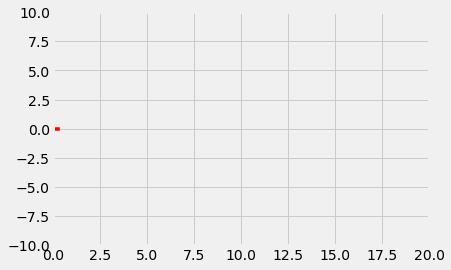

In [141]:
if __name__ == "__main__":
    steering = np.clip(np.random.randn(250), -1, 1)        # Generates values from the normal distribution clamped between [-1 1]
    throttle = np.clip(np.random.randn(250), -1, 0.75)
    x = np.array([0, 0, 0, 0, 5.0, 0.5, 0])
    state_history = []

    f = AutoRallyNet("alpha_nnet.npz")

    for i in range(250):
        state_history.append(x)
        x = f(x, steering[i], throttle[i])

    animate(np.asarray(state_history), "random_controls")

# <center> MAIN CONTROLLER <center>

In [125]:
def runPID(TIME_RUNNING_SIMULATION):   
    # Definiing Initial States and Targets
    targetIndex = 1
    x_start, y_start = x_waypoints[0], y_waypoints[0]
    x_target, y_target = x_waypoints[targetIndex], y_waypoints[targetIndex]      # Starting target positions
    x = np.array([x_start, y_start, 0, 0, 0.01, 0, 0])    # Initial state
    x_previous = x                                     # Last state, initialized at x to avoid index error
    
    # Recording Important Values
    state_history = []   
    throttle_history = []
    steering_history = []
    P_history = []
    I_history = []
    D_history = []
    
    # PID Necessary Terms:
    lastThrottleITerm = 0    # This and lastSteeringITerm needed for I term calculations
    lastSteeringITerm = 0;
    lastThrottleError = 0    # This and lastSteeringError needed for D term calculations
    lastSteeringError = 0
    
    # Necessary/Useful Constants
    PROXIMITY_THRESHOLD = 1  # Proximity to a point within which we have "reached it"
    TIME_BETWEEN_TARGETS = 5
    dtime = 0.02
    f = AutoRallyNet("alpha_nnet.npz")
    
    # Start timer and loop
    keepGoing = True
    #start_time = time.time()
    iterations = 0
    while(iterations < TIME_RUNNING_SIMULATION/dtime):
        # 1. Our current and target x and y are defined, if we're close enough to the desired, update target to next waypoint
        x_current, y_current = x[0], x[1]
        x_last, y_last = x_previous[0], x_previous[1]
        distanceToTarget = np.sqrt((x_target - x_current)**2 + (y_target - y_current)**2)
        if (distanceToTarget < PROXIMITY_THRESHOLD):
            x_start, y_start = x_target, y_target
            targetIndex += 1
            x_target, y_target = x_waypoints[targetIndex], y_waypoints[targetIndex]

        #set_trace()

        # 2.a) Compute throttle PID
        distanceBetweenPoints = np.sqrt((x_target - x_start)**2 + (y_target - y_start)**2)
        velocityTarget = distanceBetweenPoints / TIME_BETWEEN_TARGETS   # target velocity = distance / time in which you want to cover it
        velocityCurrent = x[4] # current velocity is distance traveled since last time / time elapsed
        throttleInput, lastThrottleError, lastThrottleITerm = throttlePID(velocityCurrent, velocityTarget, lastThrottleError, lastThrottleITerm, dtime)

        # 2.b) Compute steering PID
        #print(x[3] * 180 / np.pi)
        steeringInput, lastSteeringError, lastSteeringITerm, P, I = steeringPID(x_current, y_current, x_target, y_target, lastSteeringError, lastSteeringITerm, dtime, x[3])
        
        # 3. Record the current state, the throttle and steering inputs at that state, and set previous state as current state
        state_history.append(x)
        throttle_history.append(throttleInput)
        steering_history.append(steeringInput)
        P_history.append(P)
        I_history.append(I)
        x_previous = x

        # 4. Apply PID inputs and use the NN to estimate new position.
        # PROBLEM: Do it time or space based? SOLUTION? Try time interval of 0.01s first (edge case is if we're not moving, handle that too)
        x = f(x, steeringInput, throttleInput)

        #time.sleep(dtime)
        iterations += 1
    
    return (state_history, throttle_history, steering_history, x_target, y_target, P_history, I_history)

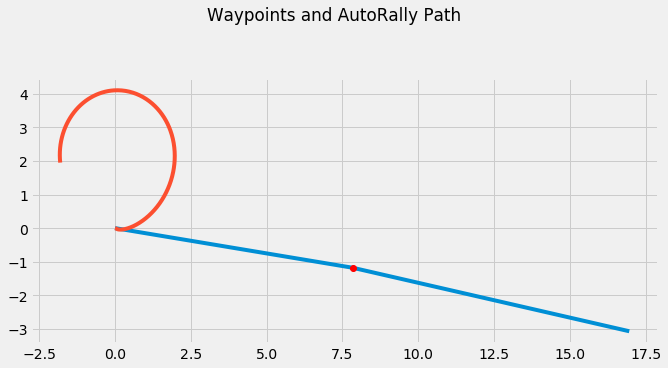

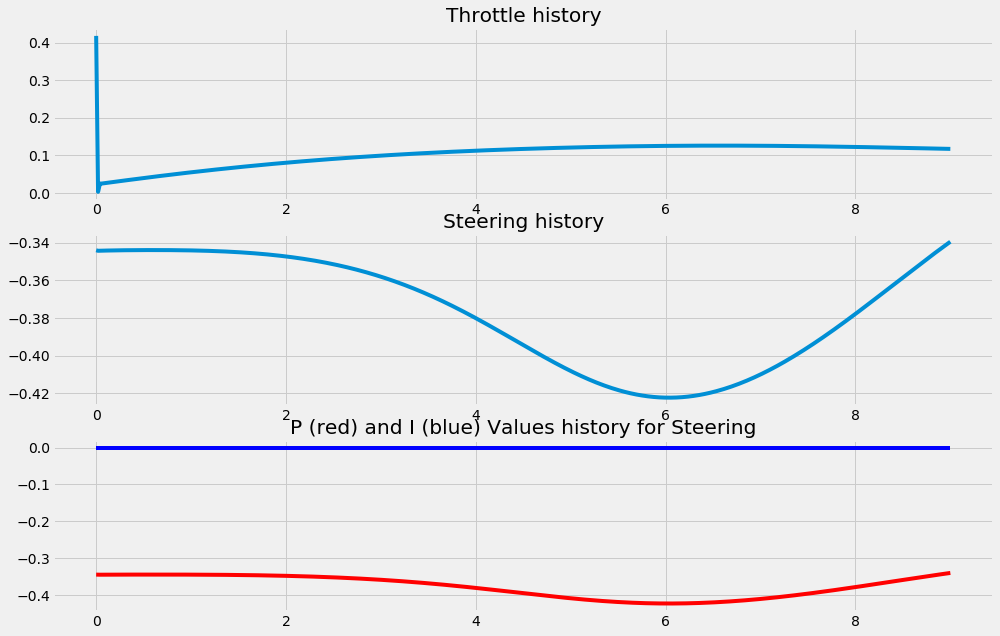

In [136]:
## NOTE: LOOK AT THE CURRENT HEADINGS, X[3], THEY'RE ALL INCORRECT, ALSO IT DOESN'T CHANGE FROM POSITIVE TO NEGATIVE AS IT SHOULD
TIME_RUNNING_SIMULATION = 9
state_history, throttle_history, steering_history, x_target, y_target, P_history, I_history= runPID(TIME_RUNNING_SIMULATION)

x_states = [row[0] for row in state_history]   # state_history is a 2D array of all the states. we get the x and y positions
y_states = [row[1] for row in state_history]
x_time = np.linspace(0, TIME_RUNNING_SIMULATION, len(throttle_history))

# PLOTTING WAYPOINTS & AUTORALLY STATE HISTORY
f1 = plt.figure(figsize=(10, 10))
ax0 = f1.add_subplot(211)
plt.plot(x_waypoints, y_waypoints, x_states, y_states, [x_target], [y_target], 'ro')
f1.suptitle(r'Waypoints and AutoRally Path')

f2, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(15, 10))
ax1.set_title(r'Throttle history')
ax1.plot(x_time, throttle_history)
ax2.set_title(r'Steering history')
ax2.plot(x_time, steering_history)
ax3.set_title(r'P (red) and I (blue) Values history for Steering')
ax3.plot(x_time, P_history, 'r', x_time, I_history, 'b')

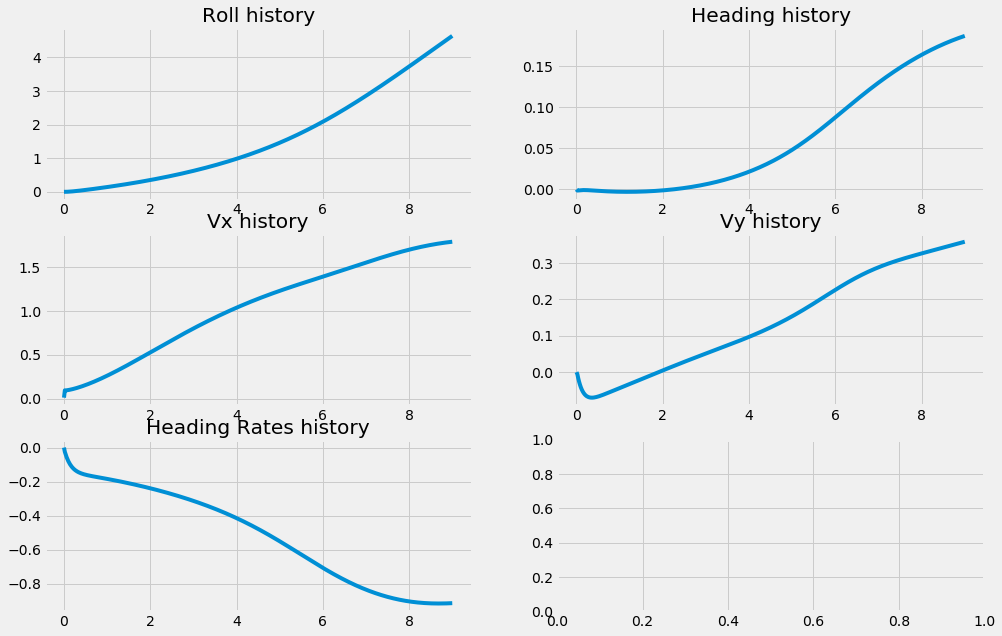

In [135]:
rolls = [i[2] for i in state_history]
headings = [i[3] for i in state_history]
vxs = [i[4] for i in state_history]
vys = [i[5] for i in state_history]
heading_rates = [i[6] for i in state_history]
f3, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 10))
ax1.set_title(r'Roll history')
ax1.plot(x_time, rolls)
ax2.set_title(r'Heading history')
ax2.plot(x_time, headings)
ax3.set_title(r'Vx history')
ax3.plot(x_time, vxs)
ax4.set_title(r'Vy history')
ax4.plot(x_time, vys)
ax5.set_title(r'Heading Rates history')
ax5.plot(x_time, heading_rates)

##  <center> Animation Attempts </center>

In [98]:
# ANIMATION ATTEMPT 1 - TKINTER
tk = Tk()
HEIGHT = 500
WIDTH = 1000
canvas = Canvas(tk, width=WIDTH, height=HEIGHT)
tk.title("Le AutoRally")
canvas.pack()

ball = canvas.create_oval(10, 10, 20, 20, fill="blue")

xspeed = 4
yspeed = 5
while True:
    canvas.move(ball, xspeed, yspeed)
    pos = canvas.coords(ball)
    if pos[3] >= HEIGHT or pos[1] <= 0:
        yspeed = -yspeed
    if pos[2] >= WIDTH or pos[0] <= 0:
        xspeed = -xspeed
    tk.update()
    time.sleep(0.015)

tk.mainloop()

TclError: invalid command name ".!canvas"

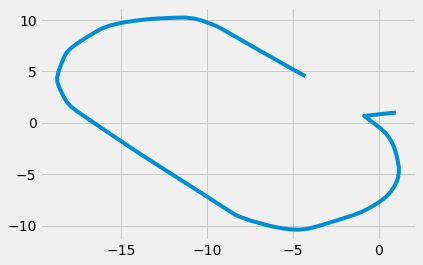

In [97]:
#style.use('fivethirtyeight')

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

#xs = [i[0] for i in state_history]
#ys = [i[1] for i in state_history]
count = 0
def animate(i):
    global count
    graph_data = open('waypoints.txt', 'r').read()
    lines = graph_data.split('\n')
    xs, ys = getWaypoints('waypoints.txt')
    count += 1
    xs.append(count)
    ys.append(count)
    ax1.clear()
    ax1.plot(xs, ys)
    
ani = animation.FuncAnimation(fig, animate, interval=1000)